In [125]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor as DTR, DecisionTreeClassifier as DTC, plot_tree
from sklearn.ensemble import (GradientBoostingClassifier as GBC,
                              RandomForestClassifier as RFC,
                              GradientBoostingRegressor as GBR,
                              RandomForestRegressor as RFR)
from scipy.stats import t
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score)
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [126]:
# Import data
data_df = pd.read_csv('2017.csv')

for year in range(2018, 2024):
    year_data = pd.read_csv(f'{year}.csv')
    data_df = pd.concat([data_df, year_data])

print(data_df.describe())

                year         season       event_id         dg_id  \
count  124771.000000  124771.000000  124771.000000  1.247710e+05   
mean     2019.995167    2020.177726     199.069487  1.431346e+04   
std         2.020806       2.021710     231.725860  8.031460e+04   
min      2017.000000    2017.000000       2.000000  2.400000e+01   
25%      2018.000000    2018.000000      13.000000  8.769000e+03   
50%      2020.000000    2020.000000      33.000000  1.383100e+04   
75%      2022.000000    2022.000000     480.000000  1.753600e+04   
max      2023.000000    2023.000000     549.000000  1.005830e+07   

           round_num     course_num     course_par     start_hole  \
count  124771.000000  124771.000000  124771.000000  124771.000000   
mean        2.213631     535.490370      71.145603       4.401039   
std         1.077864     330.998118       0.833680       4.361523   
min         1.000000       4.000000      70.000000       1.000000   
25%         1.000000     237.000000      7

In [127]:
data_df.columns

Index(['tour', 'year', 'season', 'event_completed', 'event_name', 'event_id',
       'player_name', 'dg_id', 'fin_text', 'round_num', 'course_name',
       'course_num', 'course_par', 'start_hole', 'teetime', 'round_score',
       'sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 'sg_t2g', 'sg_total',
       'driving_dist', 'driving_acc', 'gir', 'scrambling', 'prox_rgh',
       'prox_fw', 'great_shots', 'poor_shots'],
      dtype='object')

# Exploratory Analysis

## Preproccessing and Distributions

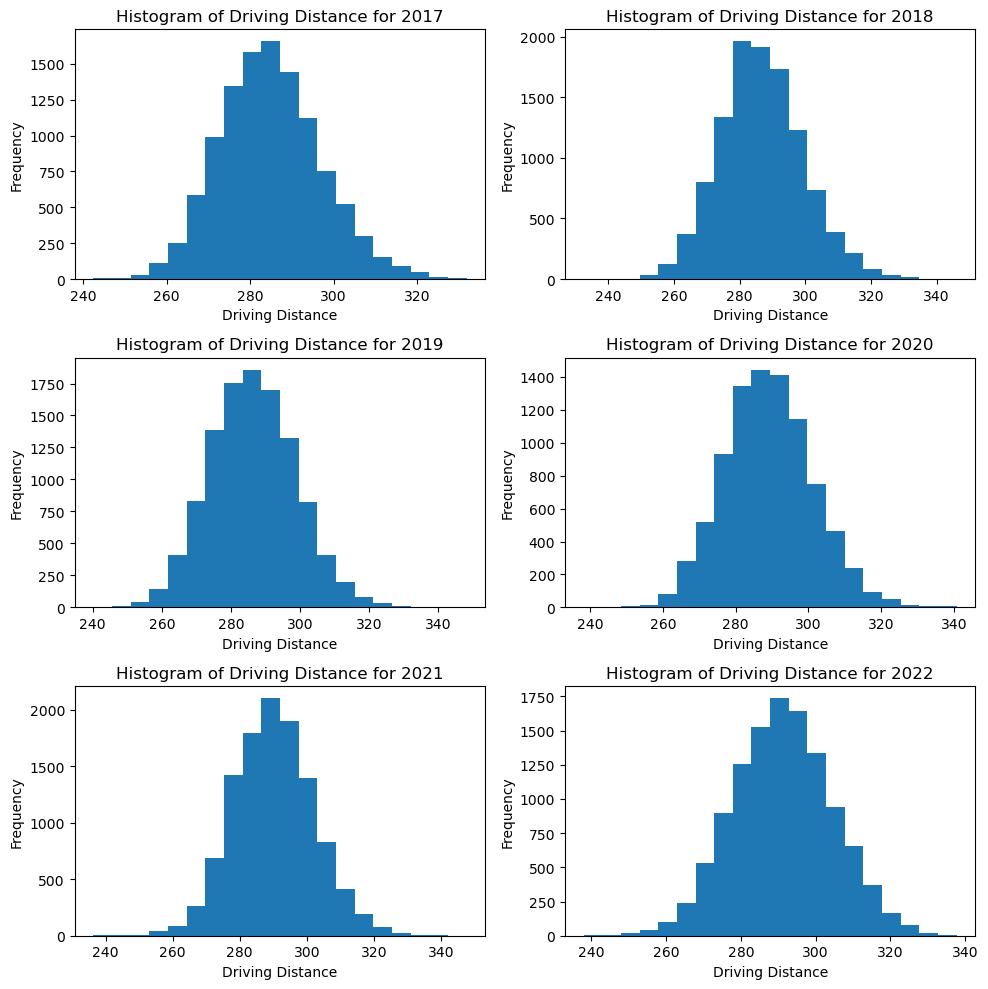

In [128]:
# Drop rows with missing values
data_df.dropna(inplace=True)
data_df.drop(['tour', 'year', 'season', 'event_name', 'course_name'], inplace=True, axis=1)

# Set "event_completed" column as datetime type with format "yyyy-mm-dd"
data_df['event_completed'] = pd.to_datetime(data_df['event_completed'], format='%Y-%m-%d')

data_df['year'] = data_df['event_completed'].dt.year
data_df['month'] = data_df['event_completed'].dt.month
data_df['day'] = data_df['event_completed'].dt.day

# Select columns
X = data_df[['event_id', 'dg_id', 'round_num', 'course_num', 'course_par', 
            'start_hole', 'teetime', 'driving_dist', 'driving_acc', 'gir', 
            'scrambling', 'prox_rgh', 'prox_fw', 'year']]
Y = data_df['round_score']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

# Create a subplot figure of (3,2)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plot histogram for each year with increased number of bins
for year, axs in zip(range(2017, 2024), axes.flatten()):
    year_data = X_train[X_train['year'] == year]
    year_data['driving_dist'].plot.hist(ax=axs, bins=20)  # Increase the number of bins to 20
    axs.set_title(f'Histogram of Driving Distance for {year}')
    axs.set_xlabel('Driving Distance')
    axs.set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

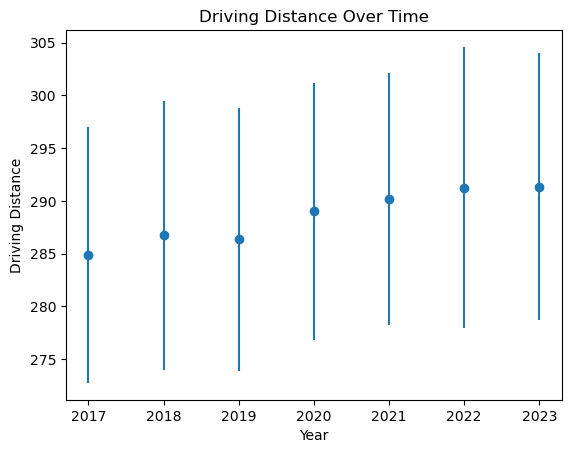

In [129]:
# Group data by year and calculate mean and standard deviation of driving distance
grouped_data = X_train.groupby('year')['driving_dist']
mean_distance = grouped_data.mean()
std_distance = grouped_data.std()

# Plot driving distance over time with error bars
plt.errorbar(mean_distance.index, mean_distance, yerr=std_distance, fmt='o')
plt.title('Driving Distance Over Time')
plt.xlabel('Year')
plt.ylabel('Driving Distance')
plt.show()

In [130]:
# Define the dependent variable (driving distance) and independent variable (time)
y = X_train['driving_dist']
X = X_train['year']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           driving_dist   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2654.
Date:                Sat, 09 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:10:57   Log-Likelihood:            -2.9895e+05
No. Observations:               75769   AIC:                         5.979e+05
Df Residuals:                   75767   BIC:                         5.979e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2043.7423     45.276    -45.140      0.0

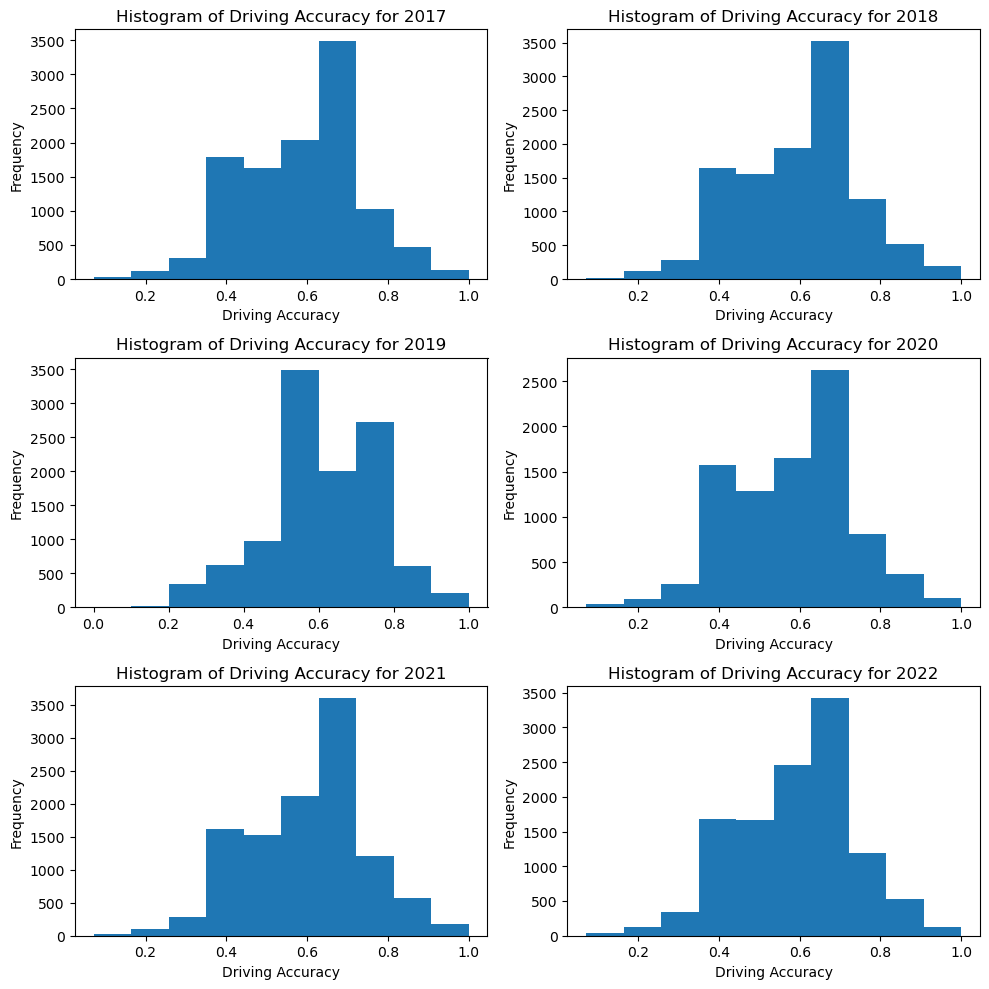

In [131]:
# Create a subplot figure of (3,2)
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Plot histogram for each year
for year, axs in zip(range(2017, 2024), axes.flatten()):
    year_data = X_train[X_train['year'] == year]
    year_data['driving_acc'].plot.hist(ax=axs)
    axs.set_title(f'Histogram of Driving Accuracy for {year}')
    axs.set_xlabel('Driving Accuracy')
    axs.set_ylabel('Frequency')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

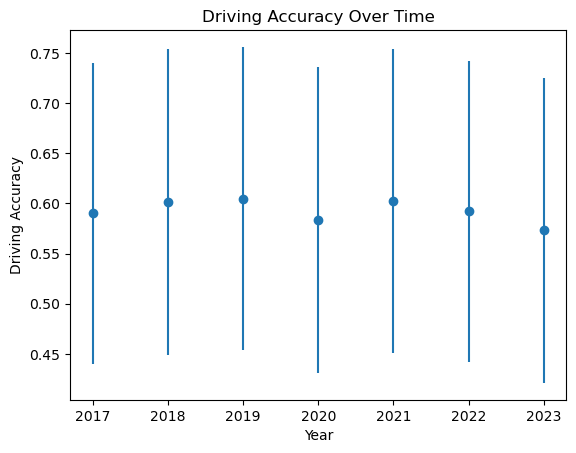

In [132]:
# Group data by year and calculate mean and standard deviation of driving accuracy
grouped_data = X_train.groupby('year')['driving_acc']
mean_accuracy = grouped_data.mean()
std_accuracy = grouped_data.std()

# Plot driving accuracy over time with error bars
plt.errorbar(mean_accuracy.index, mean_accuracy, yerr=std_accuracy, fmt='o')
plt.title('Driving Accuracy Over Time')
plt.xlabel('Year')
plt.ylabel('Driving Accuracy')
plt.show()

In [133]:
# Define the dependent variable (driving accuracy) and independent variable (time)
y = X_train['driving_acc']
X = X_train['year']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            driving_acc   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     86.00
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.84e-20
Time:                        00:10:58   Log-Likelihood:                 35402.
No. Observations:               75769   AIC:                        -7.080e+04
Df Residuals:                   75767   BIC:                        -7.078e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6820      0.549     10.354      0.0

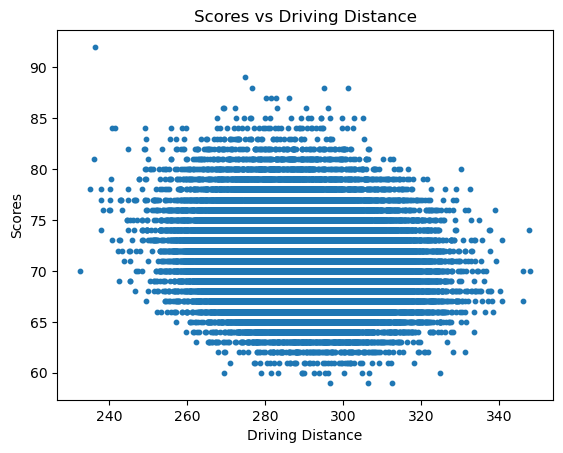

In [134]:
plt.scatter(X_train['driving_dist'], y_train, s=10)
plt.title('Scores vs Driving Distance')
plt.xlabel('Driving Distance')
plt.ylabel('Scores')
plt.show()

In [135]:
# Define the dependent variable (scores) and independent variable (driving distance)
y = y_train
X = X_train['driving_dist']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            round_score   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1851.
Date:                Sat, 09 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:10:58   Log-Likelihood:            -1.9743e+05
No. Observations:               75769   AIC:                         3.949e+05
Df Residuals:                   75767   BIC:                         3.949e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           82.3776      0.270    304.979   

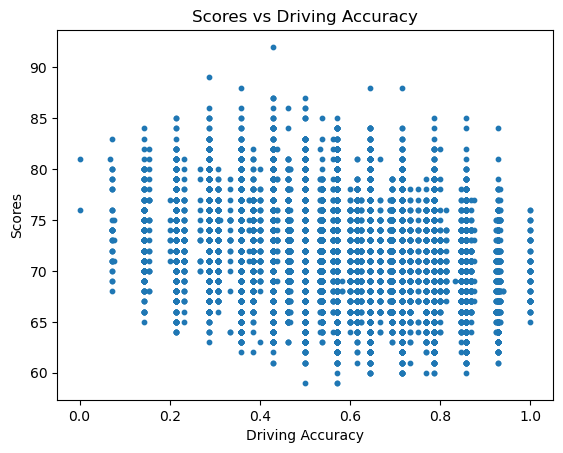

In [136]:
plt.scatter(X_train['driving_acc'], y_train, s=10)
plt.title('Scores vs Driving Accuracy')
plt.xlabel('Driving Accuracy')
plt.ylabel('Scores')
plt.show()

## Only those who completed tournament

In [137]:
# Define the predictors and target variable
finished = data_df[~data_df['fin_text'].isin(['CUT', 'WD', 'DQ', 'MDF'])].copy(deep=True)
finished = finished.sort_values('event_completed')
finished.dropna(inplace=True)

finished['score']= finished['round_score'].values - finished['course_par'].values

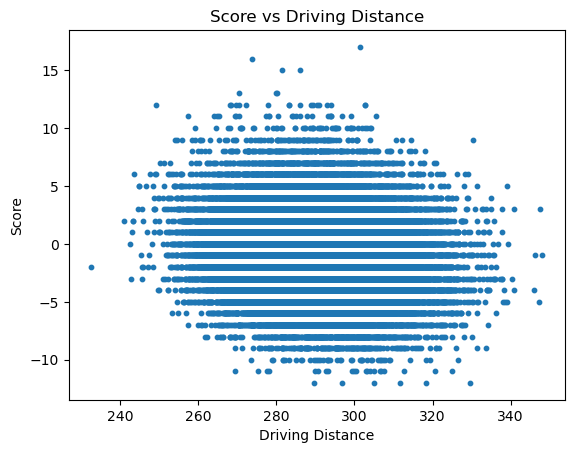

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1130.
Date:                Sat, 09 Dec 2023   Prob (F-statistic):          1.20e-245
Time:                        00:10:59   Log-Likelihood:            -1.6690e+05
No. Observations:               66827   AIC:                         3.338e+05
Df Residuals:                   66825   BIC:                         3.338e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.5345      1.477     32.851      0.0

In [138]:
plt.scatter(finished['driving_dist'], finished['score'], s=10)
plt.title('Score vs Driving Distance')
plt.xlabel('Driving Distance')
plt.ylabel('Score')
plt.show()


finished['ln_dist'] = np.log(finished['driving_dist'].values)

# Define the dependent variable (score) and independent variable (ln_dist)
y = finished['score']
X = finished['ln_dist']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

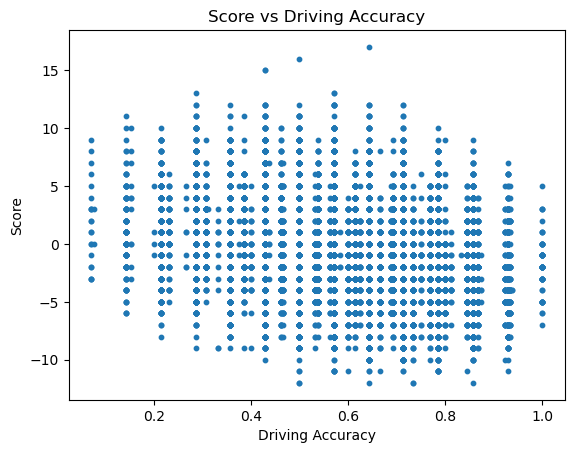

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     4305.
Date:                Sat, 09 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:10:59   Log-Likelihood:            -1.6537e+05
No. Observations:               66827   AIC:                         3.308e+05
Df Residuals:                   66825   BIC:                         3.308e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8219      0.046     39.363      

In [139]:
plt.scatter(finished['driving_acc'], finished['score'], s=10)
plt.title('Score vs Driving Accuracy')
plt.xlabel('Driving Accuracy')
plt.ylabel('Score')
plt.show()

# Define the dependent variable (score) and independent variable (driving_acc)
y = finished['score']
X = finished['driving_acc']

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

In [140]:
# Create an empty list to store the regression models
regression_models = []

# Iterate over the years
for year in range(2017, 2024):
    # Filter the data for the current year
    year_data = finished[finished['year'] == year]
    
    # Define the dependent variable (score) and independent variable (ln_dist)
    y = year_data['score']
    X = year_data['ln_dist']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    # Append the model to the list
    regression_models.append(model)

# Print the summary of each model
for year, model in zip(range(2017, 2024), regression_models):
    print(f"Regression Model for Year {year}:")
    print(model.summary())
    print()

Regression Model for Year 2017:
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     83.62
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           7.17e-20
Time:                        00:10:59   Log-Likelihood:                -24881.
No. Observations:               10071   AIC:                         4.977e+04
Df Residuals:                   10069   BIC:                         4.978e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.421

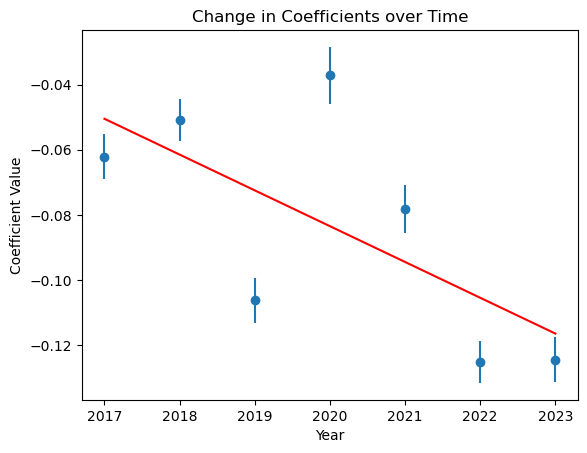

In [141]:
# Create empty lists to store the coefficients and standard errors
years = []
slopes = []
errors = []

# Iterate over the regression models
for year, model in zip(range(2017, 2024), regression_models):
    years.append(year)
    slopes.append(model.params[1] / 100)
    errors.append(model.bse[1] / 100)  # Divide the standard error by 100

# Plot the change in slopes with error bars
plt.errorbar(years, slopes, yerr=errors, fmt='o')

# Calculate the line of best fit
coefficients = np.polyfit(years, slopes, 1)
line = np.polyval(coefficients, years)

# Plot the line of best fit
plt.plot(years, line, color='red')

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Coefficient Value')
plt.title('Change in Coefficients over Time')

# Show the plot
plt.show()

In [142]:
finished['is_2020'] = (finished['year'] == 2020).astype(int)

# Define the dependent variable (score) and independent variable (ln_dist)
y = finished['score']
X = finished[['ln_dist', 'is_2020']]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     578.8
Date:                Sat, 09 Dec 2023   Prob (F-statistic):          5.80e-250
Time:                        00:10:59   Log-Likelihood:            -1.6689e+05
No. Observations:               66827   AIC:                         3.338e+05
Df Residuals:                   66824   BIC:                         3.338e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.6540      1.477     32.934      0.0

# Regression Models

## Regularized Regression

In [143]:
features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott', 
            'driving_dist', 'driving_acc', 'gir', 'scrambling', 
            'prox_rgh', 'prox_fw']

X = finished[features]
y = finished['score'].values.reshape(-1,1)


# Normalize data
X_norm = StandardScaler().fit_transform(X)
y_norm = StandardScaler().fit_transform(y)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=123)


# Define the hyperparameters to tune
param_grid = {'alpha': np.logspace(-6, 2, 20)}

# Perform grid search to find the best hyperparameters
lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, n_jobs=-1)
lasso.fit(X_norm_train, y_norm_train)

print(f'Cross-validated training score: {lasso.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = lasso.best_params_['alpha']
best_model = lasso.best_estimator_

# Evaluate the best model on the test data
test_score = best_model.score(X_norm_test, y_norm_test)

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)
print(f"Test score: {test_score:.5f}")

# Get the coefficients of the best model
coefficients = best_model.coef_.reshape(-1,1)

# Get the standard errors of the coefficients
std_errors = np.sqrt(np.diagonal(np.linalg.inv(X_norm_train.T @ X_norm_train) * np.mean(np.square(y_norm_train - X_norm_train @ coefficients), axis=0))).reshape(-1,1)

# Calculate the t-stats and p-values
t_stats = coefficients / std_errors
p_values = 2 * (1 - t.cdf(np.abs(t_stats), df=X_norm_train.shape[0] - X_norm_train.shape[1]))

# Create a DataFrame to summarize the coefficients, t-stats, p-values, and standard errors
summary_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients.flatten(),
                            'Std Error': std_errors.flatten(), 'T-Stat': t_stats.flatten(), 'P-Value': p_values.flatten()})


# Print the summary
print(summary_df)

summary_df.to_latex('reg_1.tex', index=False)

Cross-validated training score: 0.85458
Best alpha: 1.8329807108324375e-05
Test score: 0.85991
        Feature  Coefficient  Std Error      T-Stat  P-Value
0       sg_putt    -0.514393   0.001815 -283.488189      0.0
1        sg_arg    -0.296814   0.001894 -156.745432      0.0
2        sg_app    -0.279275   0.002111 -132.266717      0.0
3        sg_ott    -0.177980   0.002052  -86.717050      0.0
4  driving_dist    -0.076985   0.001868  -41.214840      0.0
5   driving_acc    -0.086562   0.002042  -42.398487      0.0
6           gir    -0.270869   0.002179 -124.328499      0.0
7    scrambling    -0.089405   0.002055  -43.506919      0.0
8      prox_rgh     0.063205   0.001715   36.853366      0.0
9       prox_fw     0.150200   0.001963   76.496437      0.0


/var/folders/c2/fhzf9hbn7rgflq5r2ss9_qr80000gn/T/ipykernel_1002/2726617519.py:54: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_df.to_latex('reg_1.tex', index=False)


## Controlling for Bias

We have concerns that since these statistics are calculated from that round's performance that they may not be completely exogenous. So instead we will use a lagged regression to predict performance. Also questions about normalization since sg categories are already calculated wrt. the PGA Tour baseline from that distance.

In [144]:
selected = finished[['year','event_id','dg_id', 'course_num', 'round_num', 'score'] + features]

selected = selected.groupby(['year', 'event_id', 'dg_id']).filter(lambda x: len(x) >= 2)
selected = selected.sort_values('round_num', ascending=True)

l1_features = []
for var in features:
    selected[f'{var}_l1'] = selected.groupby(['year', 'event_id', 'dg_id'])[var].shift(1)
    l1_features.append(f'{var}_l1')

selected = selected.dropna(subset=['sg_putt_l1'])

selected.head()

,year,event_id,dg_id,course_num,round_num,score,sg_putt,sg_arg,sg_app,sg_ott,...,sg_putt_l1,sg_arg_l1,sg_app_l1,sg_ott_l1,driving_dist_l1,driving_acc_l1,gir_l1,scrambling_l1,prox_rgh_l1,prox_fw_l1
414,2020,6,6930,6,2,-4.0,2.625,0.231,0.982,0.421,...,-1.463,-0.945,-0.466,-0.132,276.4,0.571,0.611,0.375,35.834,39.047
10253,2019,34,7489,503,2,-6.0,1.618,1.120,2.491,0.386,...,-1.964,-1.216,3.604,0.928,257.7,0.857,0.833,0.333,14.789,24.324
10796,2019,524,23604,876,2,-2.0,0.072,-0.065,-0.827,1.436,...,0.738,0.610,-0.221,0.578,302.6,0.571,0.722,1.000,25.687,25.689
3702,2023,9,10104,9,2,2.0,0.268,1.655,-3.191,0.743,...,0.111,-0.400,0.191,0.281,279.3,0.571,0.667,0.500,46.490,42.718
5598,2022,41,14967,770,2,-2.0,2.898,-1.413,1.033,-0.483,...,0.289,0.141,-0.776,1.164,303.8,0.500,0.667,0.500,51.043,32.908


In [145]:
X = selected[l1_features]
y = selected['score'].values.reshape(-1, 1)

# Normalize data
X_norm = StandardScaler().fit_transform(X)
y_norm = StandardScaler().fit_transform(y)

X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=123)

# Define the hyperparameters to tune
param_grid = {'alpha': np.logspace(-6, 2, 20)}

# Perform grid search to find the best hyperparameters
lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, n_jobs=-1)
lasso.fit(X_norm_train, y_norm_train)

print(f'Cross-validated training score: {lasso.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = lasso.best_params_['alpha']
best_model = lasso.best_estimator_

# Evaluate the best model on the test data
test_score = best_model.score(X_norm_test, y_norm_test)

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)
print(f"Test score: {test_score:.5f}")

# Get the coefficients of the best model
coefficients = best_model.coef_.reshape(-1,1)

# Get the standard errors of the coefficients
std_errors = np.sqrt(np.diagonal(np.linalg.inv(X_norm_train.T @ X_norm_train) * np.mean(np.square(y_norm_train - X_norm_train @ coefficients), axis=0))).reshape(-1,1)

# Calculate the t-stats and p-values
t_stats = coefficients / std_errors
p_values = 2 * (1 - t.cdf(np.abs(t_stats), df=X_norm_train.shape[0] - X_norm_train.shape[1]))

# Create a DataFrame to summarize the coefficients, t-stats, p-values, and standard errors
summary_df = pd.DataFrame({'Feature': l1_features, 'Coefficient': coefficients.flatten(),
                            'Std Error': std_errors.flatten(), 'T-Stat': t_stats.flatten(), 'P-Value': p_values.flatten()})

# Print the summary
print(summary_df)

summary_df.to_latex('reg_2.tex', index=False)

Cross-validated training score: 0.05905
Best alpha: 1e-06
Test score: 0.05963
           Feature  Coefficient  Std Error     T-Stat       P-Value
0       sg_putt_l1     0.041162   0.005384   7.645239  2.131628e-14
1        sg_arg_l1     0.038191   0.005610   6.807616  1.006617e-11
2        sg_app_l1     0.154981   0.006278  24.687861  0.000000e+00
3        sg_ott_l1     0.059452   0.006150   9.666309  0.000000e+00
4  driving_dist_l1    -0.097855   0.005557 -17.609018  0.000000e+00
5   driving_acc_l1    -0.045770   0.006075  -7.534283  5.018208e-14
6           gir_l1    -0.196880   0.006422 -30.656151  0.000000e+00
7    scrambling_l1    -0.047641   0.006057  -7.865313  3.774758e-15
8      prox_rgh_l1     0.047310   0.005102   9.273439  0.000000e+00
9       prox_fw_l1     0.090193   0.005823  15.489560  0.000000e+00


/var/folders/c2/fhzf9hbn7rgflq5r2ss9_qr80000gn/T/ipykernel_1002/552586129.py:47: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary_df.to_latex('reg_2.tex', index=False)


## Pruned Decision Tree Regression

Depth of tree: 43
Best ccp_alpha: 0.004453626763478505
Cross validated training score: 0.07344
Test score: 0.07122


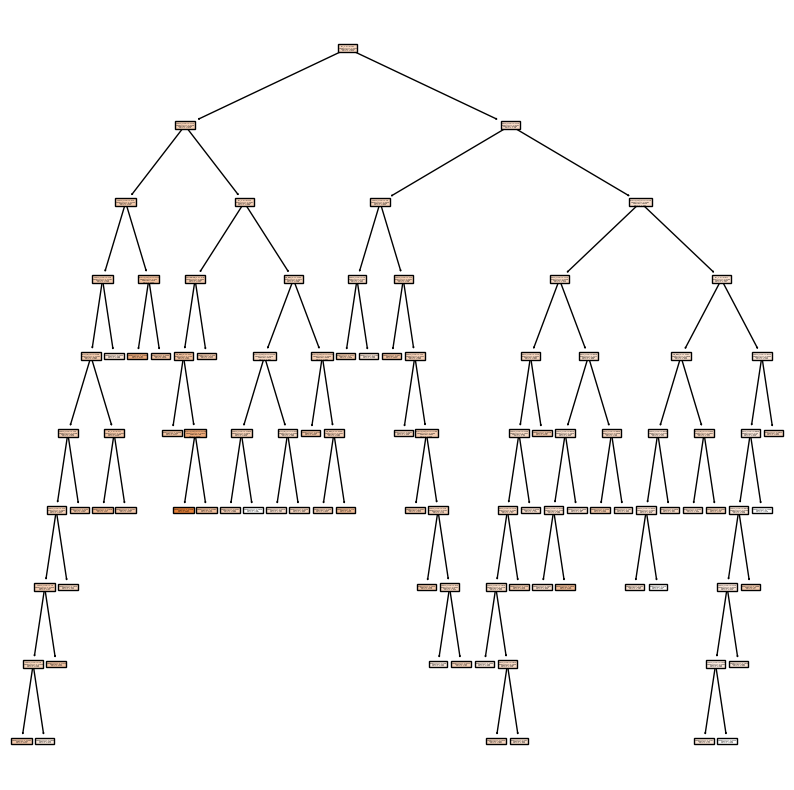

In [146]:
# Define the features and target variable
X = np.hstack((X, selected['course_num'].values.reshape(-1,1)))
l1_features.append('course_num')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create an instance of the DecisionTreeRegressor
tree = DTR()

# Fit the decision tree regressor to the data
tree.fit(X_train, y_train)

# Print depth of tree
print("Depth of tree:", tree.get_depth())

# Perform cost complexity pruning
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

# Perform grid search to find the best hyperparameters
pruned = RandomizedSearchCV(tree, {'ccp_alpha': ccp_alphas}, cv=5, n_iter=1000, 
                            n_jobs=-1, random_state=123)
pruned.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_ccp_alpha = pruned.best_params_['ccp_alpha']
best = pruned.best_estimator_

print("Best ccp_alpha:", best_ccp_alpha)
print(f"Cross validated training score: {pruned.best_score_.mean():.5f}")

test_score = best.score(X_test, y_test)
print(f"Test score: {test_score:.5f}")

# Plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(best, feature_names=l1_features, filled=True)
plt.show()

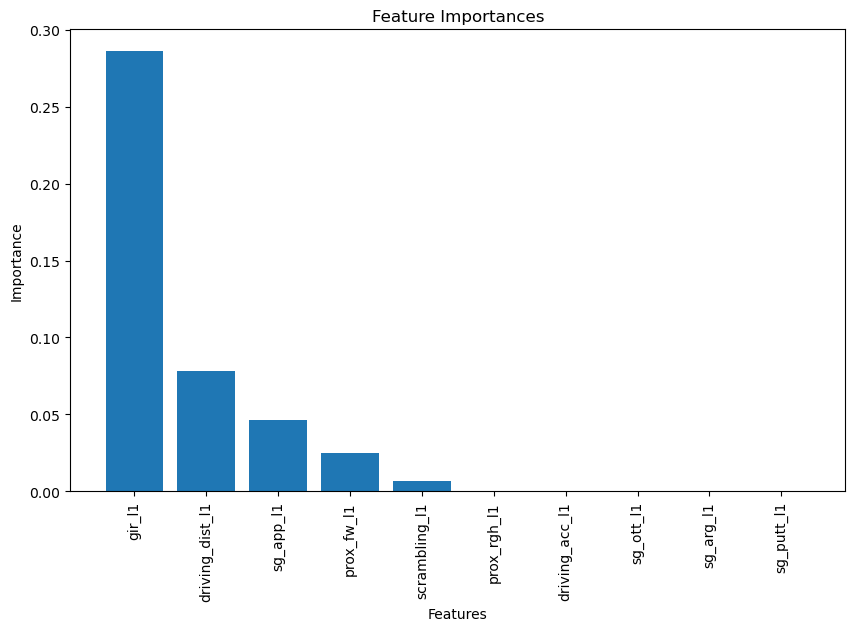

In [147]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1][1:]

# Now the rest of your code should work
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)-1), importances[indices])
plt.xticks(range(len(importances)-1), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Gradient Boosting Regression

In [148]:
# Create an instance of the GradientBoostingRegressor
boosting_tree = GBR(n_estimators=1000,
                    learning_rate=0.001,
                    max_depth=None,
                    random_state=123)

param_grid = {'max_depth': range(2,9)}

# Hyperparameter tuning
model = GridSearchCV(boosting_tree, param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train.ravel())

# Get the best hyperparameters and the best model
best_depth = model.best_params_['max_depth']
best = model.best_estimator_

print("Best max depth:", best_depth)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

test_score = best.score(X_test, y_test.ravel())
print(f"Test score: {test_score:.5f}")

Best number of terminal nodes: 60
Cross validated training score: 0.07987
Test score: 0.08525


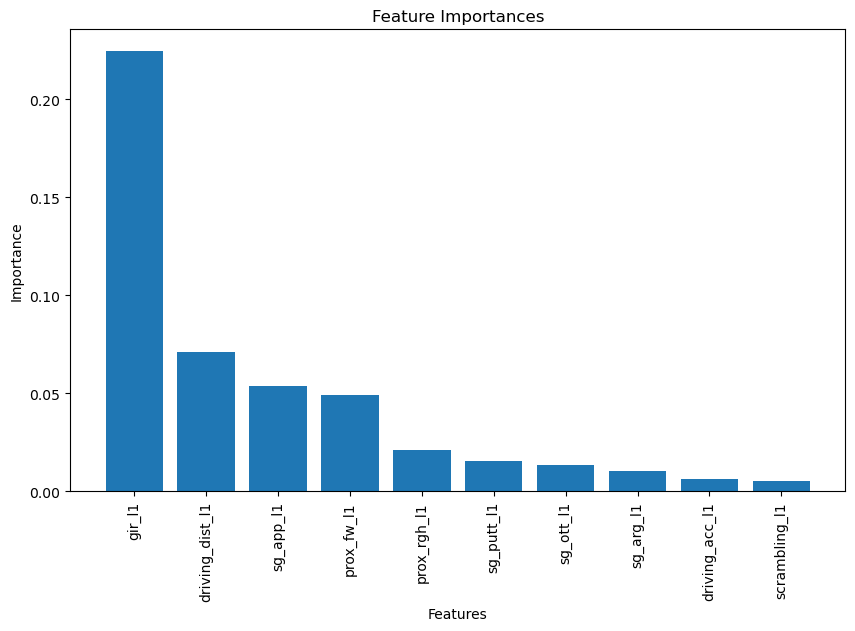

In [149]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1][1:]

# Now the rest of your code should work
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)-1), importances[indices])
plt.xticks(range(len(importances)-1), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Random Forest Regression

In [150]:
# Create an instance of the RandomForestRegressor
random_forest = RFR(n_estimators=1000, n_jobs=-1, random_state=123)

param_grid = {'max_depth': range(2,9)}

# Hyperparameter tuning
model = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1)
model.fit(X_train, y_train.ravel())

# Get the best hyperparameters and the best model
best_depth = model.best_params_['max_depth']
best = model.best_estimator_

print("Best max depth:", best_depth)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

test_score = best.score(X_test, y_test.ravel())
print(f"Test score: {test_score:.5f}")

Best number of terminal nodes: 60
Cross validated training score: 0.08419
Test score: 0.08971


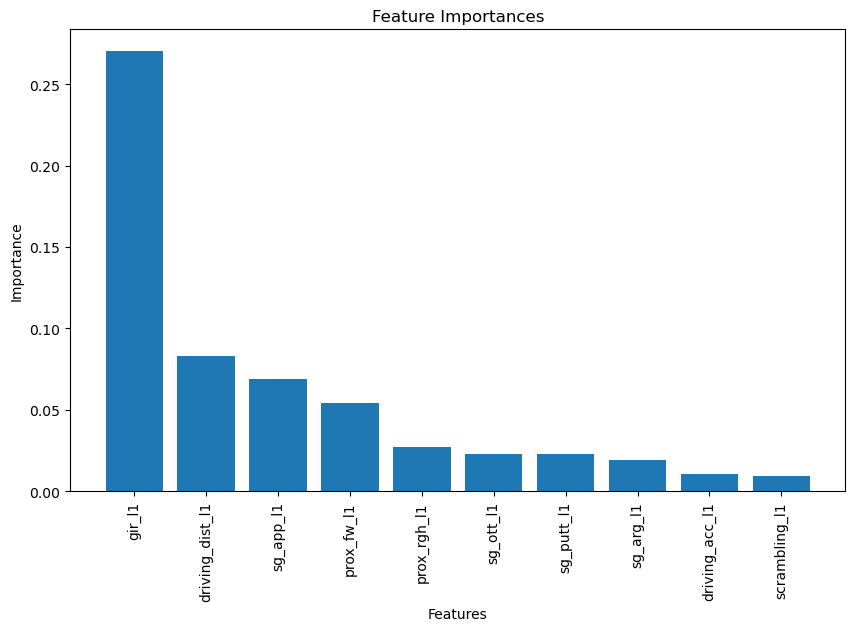

In [151]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1][1:]

# Now the rest of your code should work
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)-1), importances[indices])
plt.xticks(range(len(importances)-1), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

# Probabilistic Modeling

## Preprocessing

In [152]:
finished['fin_text'] = finished['fin_text'].str.replace('T', '')

finished['top_20'] = np.where(finished['fin_text'].astype(int) <= 20, 1, 0)

filtered = finished.groupby(['year', 'event_id', 'dg_id']).filter(lambda x: len(x) == 4).copy(deep=True)

averaged_data = filtered.groupby(['year','event_id', 'dg_id']).agg({'sg_putt': 'sum', 
                                                                    'sg_arg': 'sum', 
                                                                    'sg_app': 'sum', 
                                                                    'sg_ott': 'sum', 
                                                                    'driving_dist': 'mean',
                                                                    'gir': 'mean', 
                                                                    'top_20': 'mean',
                                                                    'driving_acc': 'mean',
                                                                    'scrambling': 'mean', 
                                                                    'prox_rgh': 'mean', 
                                                                    'prox_fw': 'mean', 
                                                                    'great_shots': 'sum', 
                                                                    'poor_shots': 'sum'})

averaged_data = averaged_data.sort_values('year', ascending=True).reset_index()

l1_features = []
for var in features:
    averaged_data[f'{var}_l1'] = averaged_data.groupby(['year', 'dg_id'])[var].shift(1)
    l1_features.append(f'{var}_l1')

averaged_data = averaged_data.dropna(subset=['sg_putt_l1'])

averaged_data.head()

,year,event_id,dg_id,sg_putt,sg_arg,sg_app,sg_ott,driving_dist,top_20,driving_acc,...,poor_shots,sg_putt_l1,sg_arg_l1,sg_app_l1,sg_ott_l1,driving_dist_l1,driving_acc_l1,scrambling_l1,prox_rgh_l1,prox_fw_l1
68,2017,41,18695,7.843,6.302,-6.190,-3.629,292.775,0.0,0.49975,...,18.0,1.128,-1.315,0.519,2.551,298.325,0.53575,0.48000,60.42825,39.55625
72,2017,41,17536,0.573,-0.349,0.186,0.916,286.775,0.0,0.62500,...,19.0,-1.167,0.780,7.801,0.467,290.950,0.62500,0.51350,43.04150,29.28975
74,2017,41,16602,-0.102,-2.646,5.660,-0.584,297.125,0.0,0.53575,...,16.0,2.496,2.482,-5.126,-0.970,294.425,0.42850,0.57800,69.13875,39.73425
78,2017,41,15575,-2.471,-1.440,3.453,0.785,285.025,0.0,0.53550,...,17.0,3.317,-0.211,5.422,0.351,296.425,0.60700,0.64400,35.40450,32.77750
83,2017,41,14606,0.898,0.937,3.182,1.311,275.575,0.0,0.73225,...,11.0,4.243,-2.905,-2.928,1.471,285.475,0.64275,0.56725,49.23350,38.94875


## Logistic Regression

In [153]:
X = averaged_data[l1_features]
y = averaged_data['top_20']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the range of C values to search
param_grid = {'C': np.logspace(-4, 4, 20)}

# Create a logistic regression model with L1 penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with cross-validation
model = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
model.fit(X_train, y_train)

print(f'Cross-validated training score: {model.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = model.best_params_
best_model = model.best_estimator_

# Compute the predicted probabilities for the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"ROC AUC score: {roc_auc:.5f}")

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)

# Get the coefficients of the best model
coefficients = best_model.coef_[0]

# Create a DataFrame to summarize the coefficients
coefficients_df = pd.DataFrame({'Feature': l1_features, 'Coefficient': coefficients})

# Print the coefficients DataFrame
print(coefficients_df)

Cross-validated training score: 0.57239
ROC AUC score: 0.58123
Best alpha: {'C': 1438.44988828766}
           Feature  Coefficient
0       sg_putt_l1     0.017987
1        sg_arg_l1     0.026354
2        sg_app_l1     0.044677
3        sg_ott_l1     0.044532
4  driving_dist_l1     0.017329
5   driving_acc_l1     0.101804
6    scrambling_l1    -0.268339
7      prox_rgh_l1     0.001401
8       prox_fw_l1     0.003625


In [154]:
# Normalize data
X_norm = StandardScaler().fit_transform(X)

X_norm_train, X_norm_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=123)

# Define the range of C values to search
param_grid = {'C': np.logspace(-6, 2, 100)}

# Create a logistic regression model with L1 penalty
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)

# Perform grid search with cross-validation
model = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
model.fit(X_norm_train, y_train)

print(f'Cross-validated training score: {model.best_score_.mean():.5f}')

# Get the best hyperparameters and the best model
best_alpha = model.best_params_
best_model = model.best_estimator_

# Compute the predicted probabilities for the test data
y_pred_proba = best_model.predict_proba(X_norm_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"ROC AUC score: {roc_auc:.5f}")

# Print the best hyperparameters and the test score
print("Best alpha:", best_alpha)

# Get the coefficients of the best model
coefficients = best_model.coef_[0]

# Create a DataFrame to summarize the coefficients
coefficients_df = pd.DataFrame({'Feature': l1_features, 'Coefficient': coefficients})

# Print the coefficients DataFrame
print(coefficients_df)

Cross-validated training score: 0.57252
ROC AUC score: 0.58121
Best alpha: {'C': 0.45348785081285914}
           Feature  Coefficient
0       sg_putt_l1     0.057017
1        sg_arg_l1     0.055050
2        sg_app_l1     0.141735
3        sg_ott_l1     0.103674
4  driving_dist_l1     0.199082
5   driving_acc_l1     0.009990
6    scrambling_l1    -0.022967
7      prox_rgh_l1     0.020448
8       prox_fw_l1     0.015146


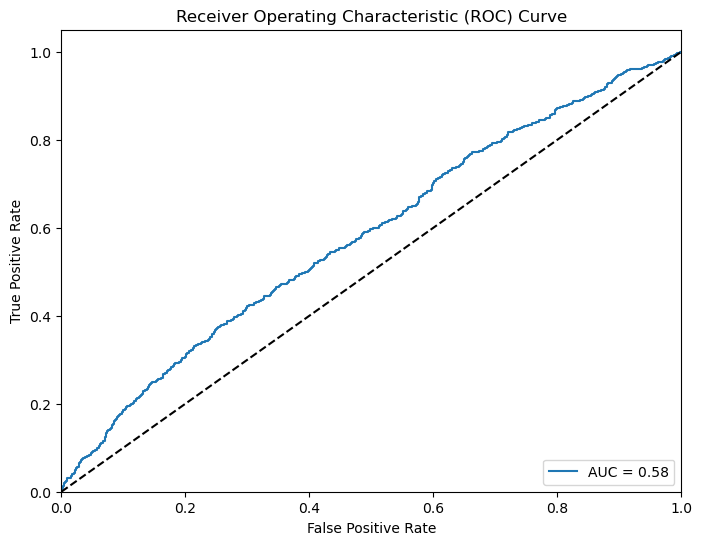

In [155]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

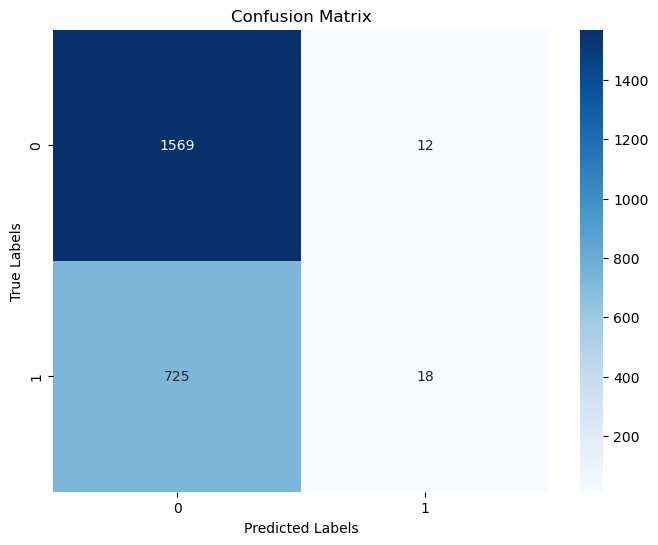

In [156]:
# Compute the predicted labels for the test data
y_pred = best_model.predict(X_norm_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Compute optimal decision threshold
# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

dist = np.sqrt((1-tpr)**2+(fpr)**2)

optimal_threshold = thresholds[np.argmin(dist)]
print(f"Optimal threshold: {optimal_threshold:.5f}")

In [ ]:
# Compute the predicted labels for the test data
y_pred = (y_probs >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Decision Tree

Depth of tree: 49
794
Best ccp_alpha: 0.001178240316718926
Cross validated training score: 0.55594
Test ROC AUC score: 0.55551


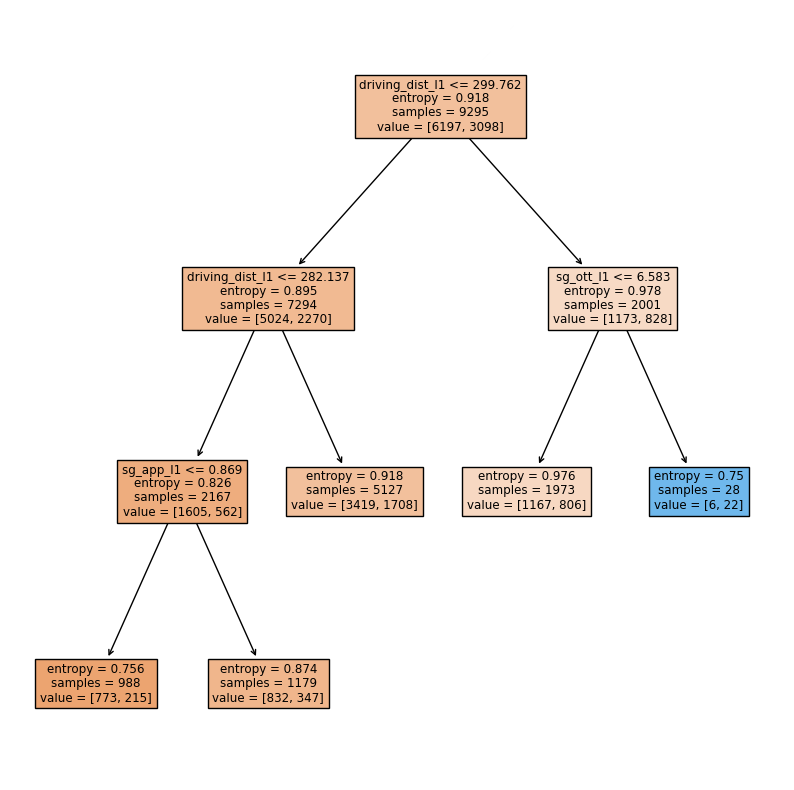

In [158]:
l1_features.append('event_id')
X = averaged_data[l1_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create an instance of the DecisionTreeClassifier
tree = DTC(criterion='entropy')

# Fit the decision tree regressor to the data
tree.fit(X_train, y_train)

# Print depth of tree
print("Depth of tree:", tree.get_depth())

# Perform cost complexity pruning
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]

print(len(ccp_alphas))

# Perform grid search to find the best hyperparameters
pruned = GridSearchCV(tree, {'ccp_alpha': ccp_alphas}, cv=5, n_jobs=-1, scoring='roc_auc')
pruned.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_ccp_alpha = pruned.best_params_['ccp_alpha']
best = pruned.best_estimator_

print("Best ccp_alpha:", best_ccp_alpha)
print(f"Cross validated training score: {pruned.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

# Plot the decision tree
plt.figure(figsize=(10, 10))
plot_tree(best, feature_names=l1_features, filled=True)
plt.show()

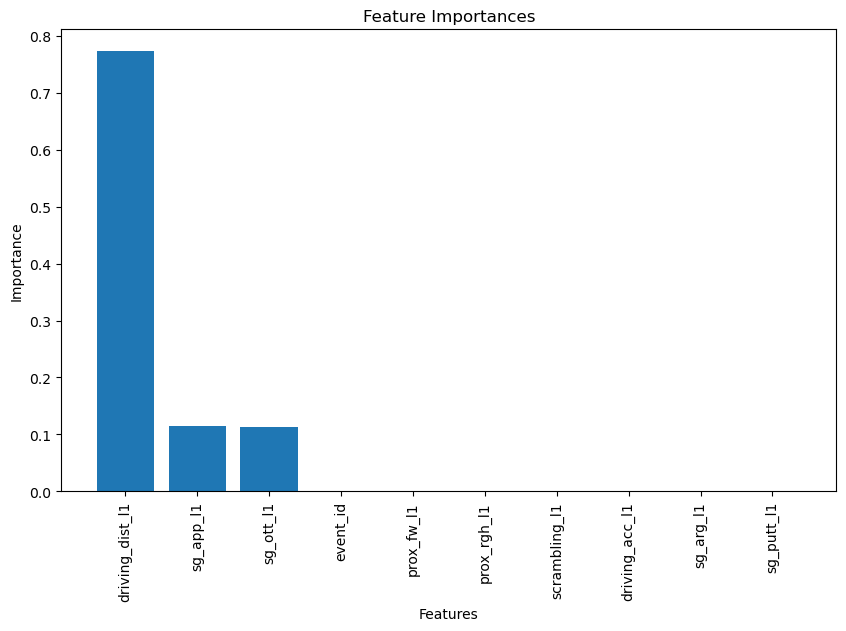

In [159]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

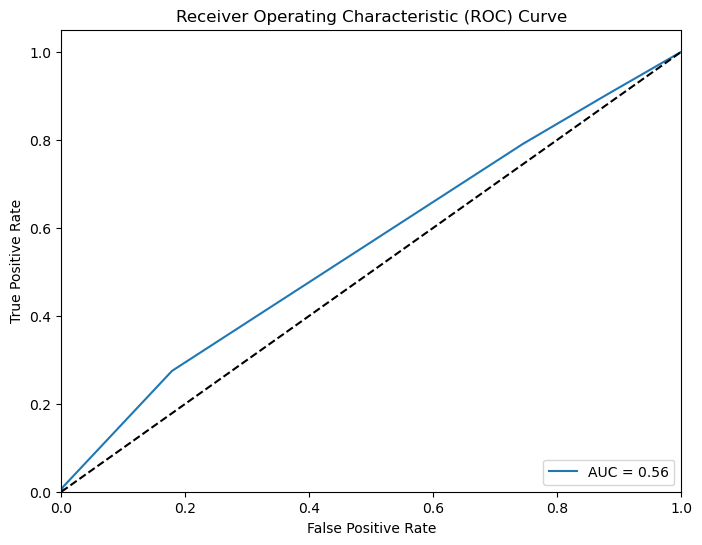

Accuracy: 0.6828743545611016
Precision: 0.6
Recall: 0.024226110363391656
F1 Score: 0.04657179818887452


In [160]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

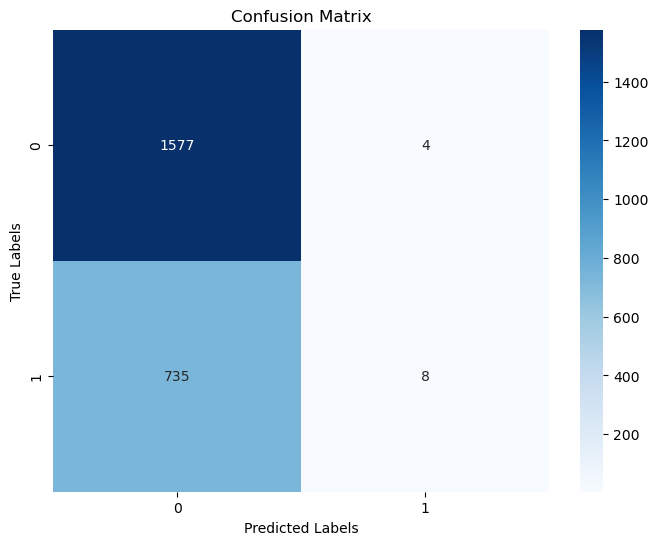

Accuracy: 0.6820137693631669
Precision: 0.6666666666666666
Recall: 0.010767160161507403
F1 Score: 0.021192052980132454


In [161]:
# Compute the predicted labels for the test data
y_pred = best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
# Compute optimal decision threshold
# Get predicted probabilities for the positive class
y_probs = best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

dist = np.sqrt((1-tpr)**2+(fpr)**2)

optimal_threshold = thresholds[np.argmin(dist)]
print(f"Optimal threshold: {optimal_threshold:.5f}")

In [ ]:
# Compute the predicted labels for the test data
y_pred = (y_probs >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Gradient Boosting Classifier

In [166]:
# Create an instance of the GradientBoostingClassifier
boosting_tree = GBC(n_estimators=1000,
                    learning_rate=0.001,
                    max_depth=None,
                    random_state=123)

param_grid = {'max_leaf_nodes': range(8,33,2)}

# Hyperparameter tuning
model = GridSearchCV(boosting_tree, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_nodes = model.best_params_['max_leaf_nodes']
best = model.best_estimator_

print("Best number of terminal nodes:", best_nodes)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC: {roc_auc:.5f}")

Best number of terminal nodes: 8
Cross validated training score: 0.57234
Test ROC AUC: 0.57681


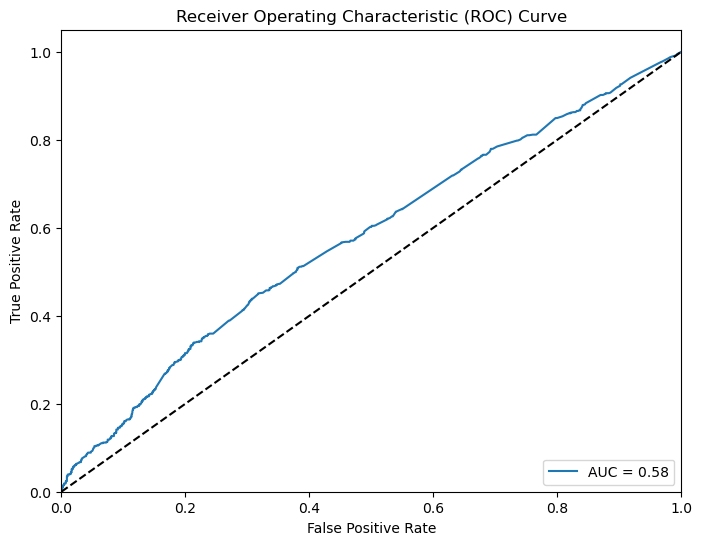

In [167]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

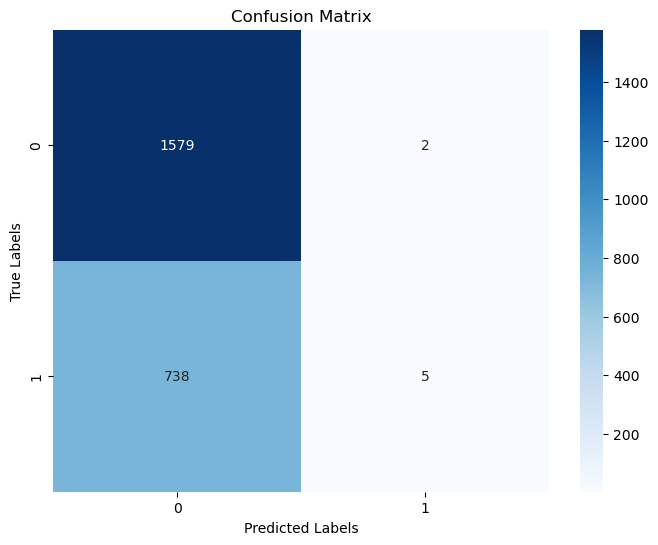

Accuracy: 0.6815834767641996
Precision: 0.7142857142857143
Recall: 0.006729475100942127
F1 Score: 0.013333333333333332


In [168]:
# Compute the predicted labels for the test data
y_pred = best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [184]:
# Compute optimal decision threshold
# Get predicted probabilities for the positive class
y_probs = best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

dist = np.sqrt((1-tpr)**2+(fpr)**2)

optimal_threshold = thresholds[np.argmin(dist)]
print(f"Optimal threshold: {optimal_threshold:.5f}")

Optimal threshold: 0.32568


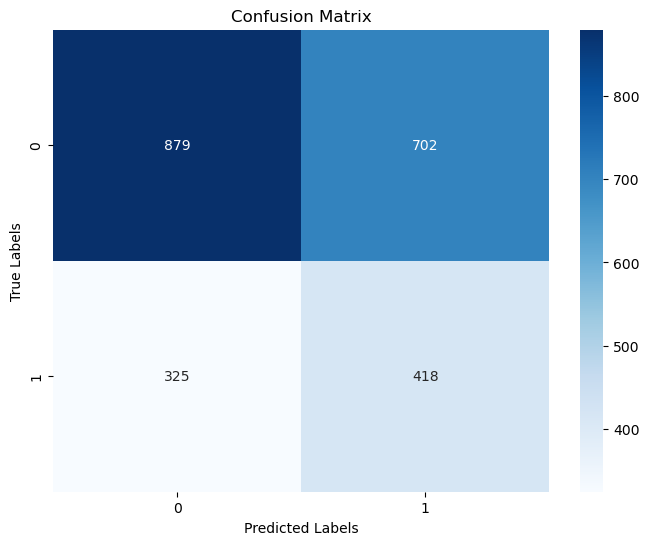

Accuracy: 0.5580895008605852
Precision: 0.3732142857142857
Recall: 0.5625841184387618
F1 Score: 0.4487385936661299


In [185]:
# Compute the predicted labels for the test data
y_pred = (y_probs >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

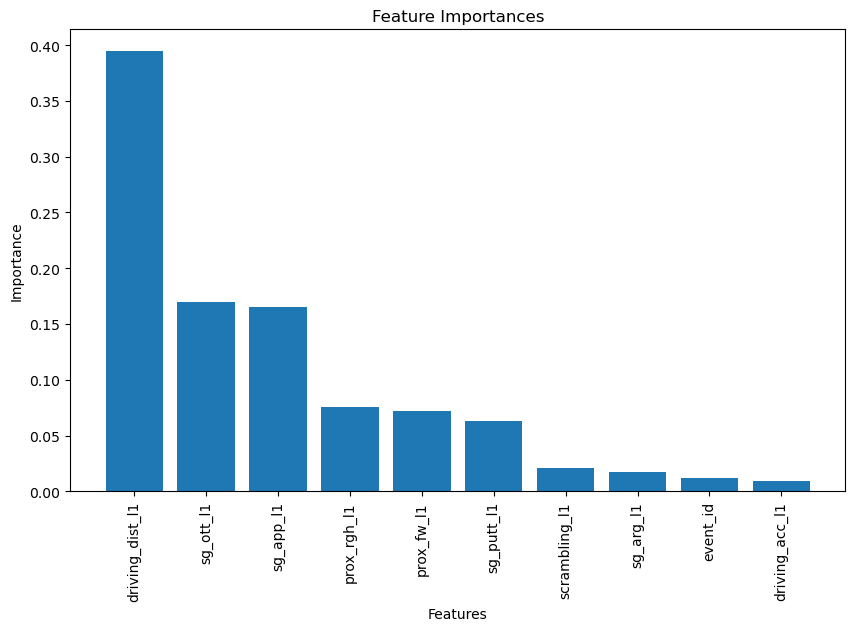

In [171]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Random Forest Classifier

In [172]:
# Create an instance of the RandomForestClassifier
random_forest = RFC(n_estimators=1000, criterion='entropy', 
                    n_jobs=-1, random_state=123)

param_grid = {'max_leaf_nodes': range(8,33,2)}

# Regularize by number of terminal nodes
model = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
model.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_nodes = model.best_params_['max_leaf_nodes']
best = model.best_estimator_

print("Best number of terminal nodes:", best_nodes)
print(f"Cross validated training score: {model.best_score_.mean():.5f}")

# Compute the predicted probabilities for the test data
y_pred_proba = best.predict_proba(X_test)[:, 1]

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the ROC AUC score
print(f"Test ROC AUC score: {roc_auc:.5f}")

Best number of terminal nodes: 26
Cross validated training score: 0.57393
Test ROC AUC score: 0.57897


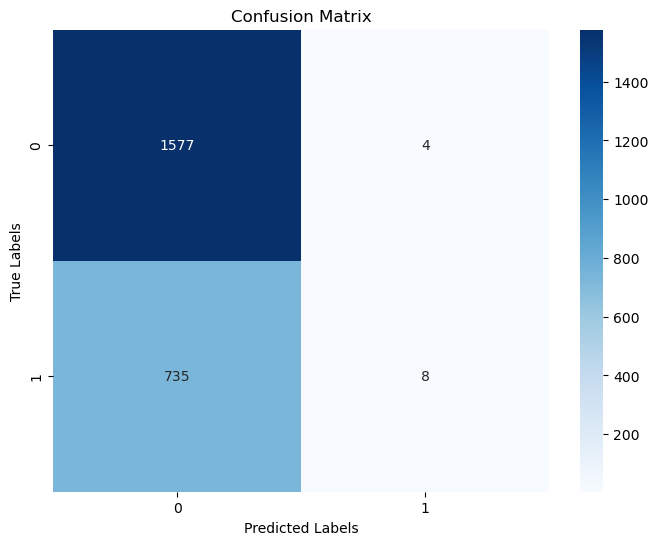

Accuracy: 0.6820137693631669
Precision: 0.6666666666666666
Recall: 0.010767160161507403
F1 Score: 0.021192052980132454


In [173]:
# Compute the predicted labels for the test data
y_pred = best.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

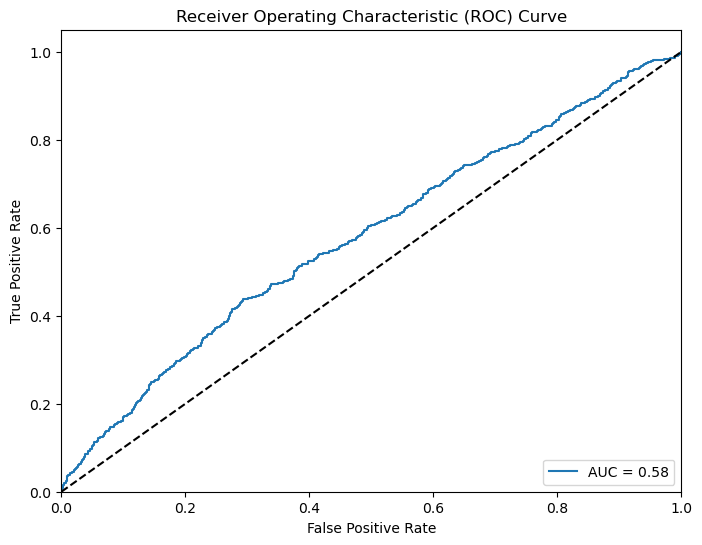

In [174]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [175]:
# Compute optimal decision threshold
# Get predicted probabilities for the positive class
y_probs = best.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

dist = np.sqrt((1-tpr)**2+(fpr)**2)

optimal_threshold = thresholds[np.argmin(dist)]
print(f"Optimal threshold: {optimal_threshold:.5f}")

Optimal threshold: 0.43875


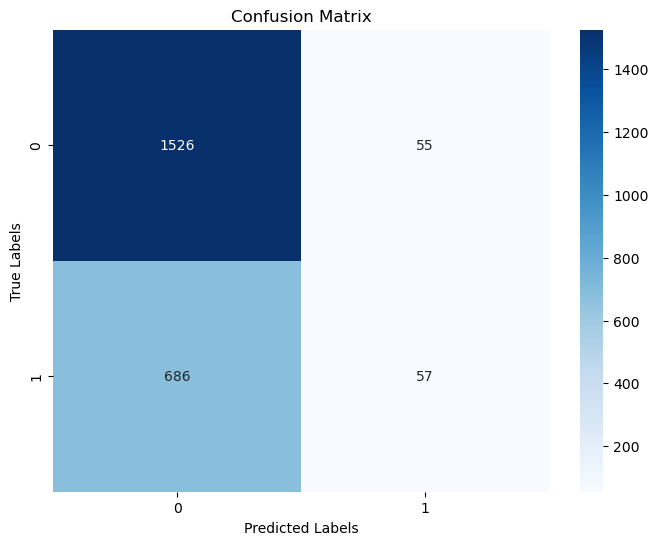

Accuracy: 0.6811531841652324
Precision: 0.5089285714285714
Recall: 0.07671601615074024
F1 Score: 0.13333333333333333


In [176]:
# Compute the predicted labels for the test data
y_pred = (y_probs >= optimal_threshold).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

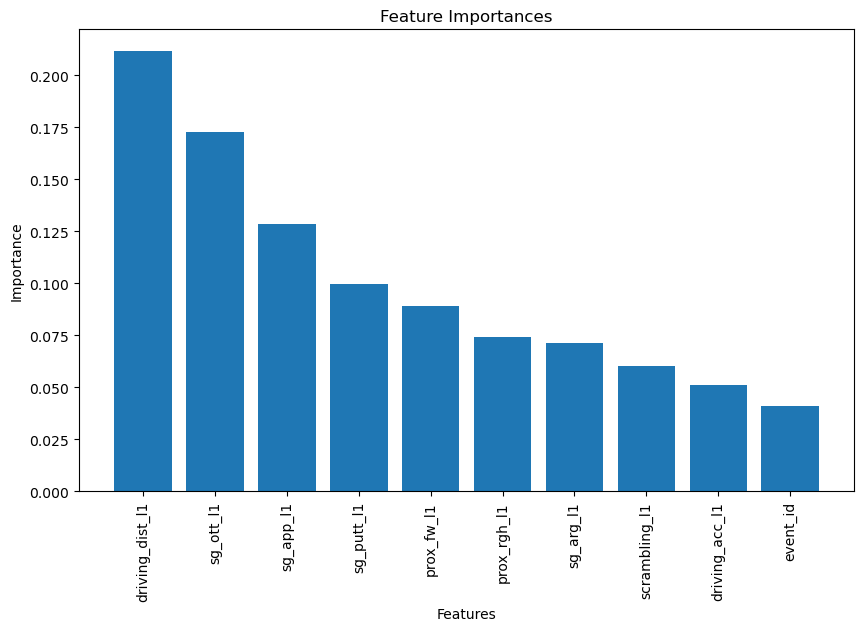

In [177]:
# Get the feature importances from the trained decision tree model
importances = best.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(l1_features)[indices.astype(int)], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

## Aside: Comparing Distributions of Driving Distance and Accuracy from each tournament over the years

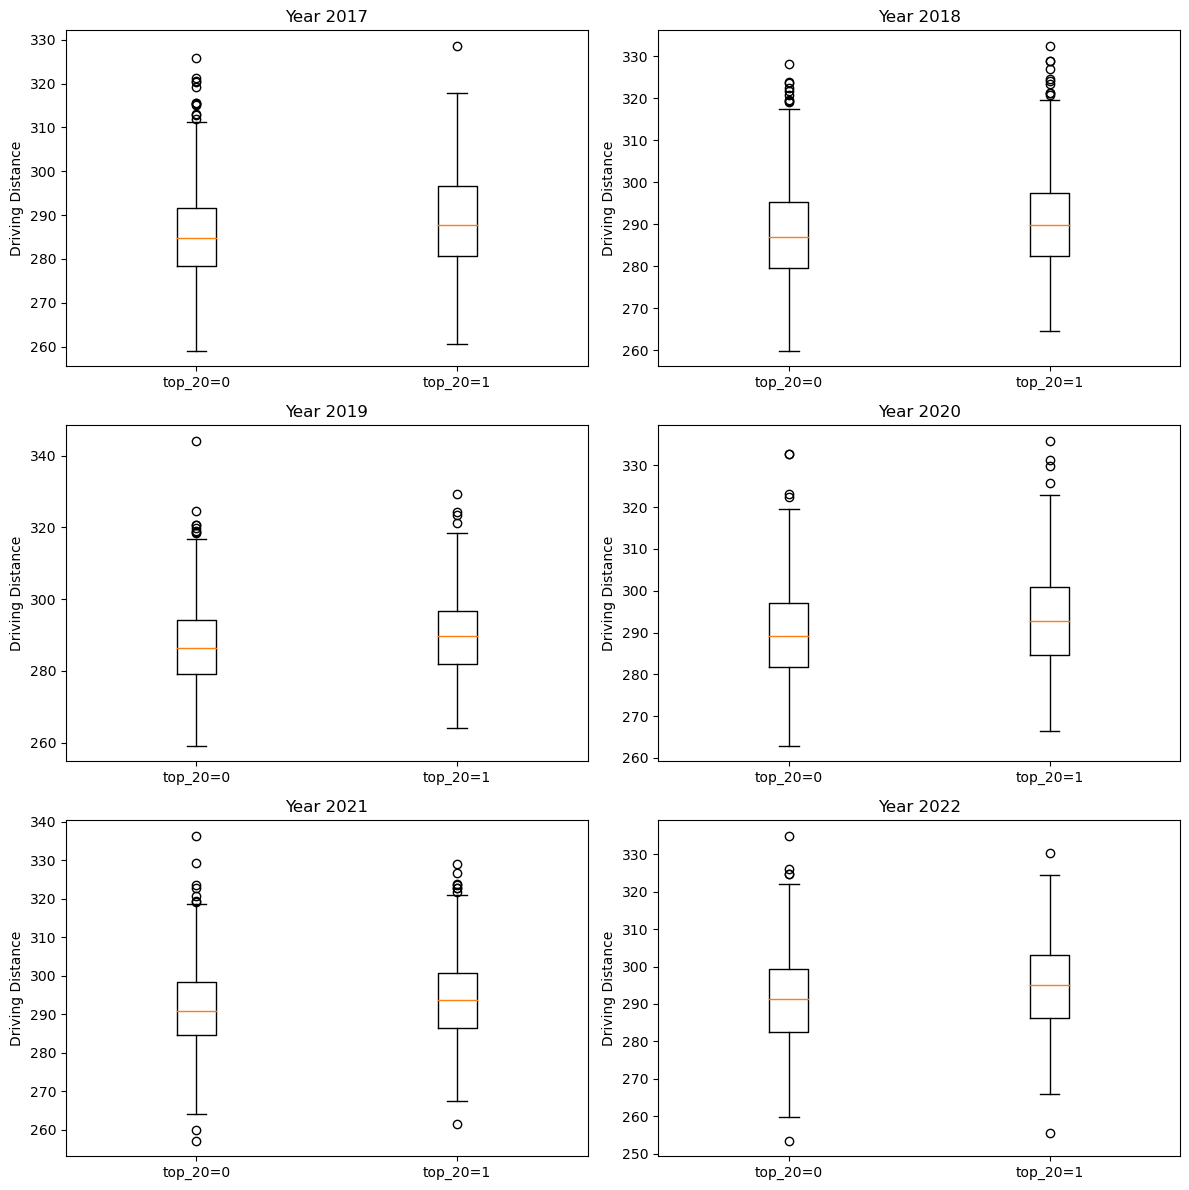

In [178]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for year, axs in zip(np.unique(averaged_data['year'].values), axes.flatten()):
    # Get the driving distance data for top_20=0 and top_20=1 for the current year
    driving_dist_0 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 0)]['driving_dist']
    driving_dist_1 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 1)]['driving_dist']
    
    # Create boxplots for the current year
    axs.boxplot([driving_dist_0, driving_dist_1], labels=['top_20=0', 'top_20=1'])
    axs.set_title(f'Year {year}')
    axs.set_ylabel('Driving Distance')

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

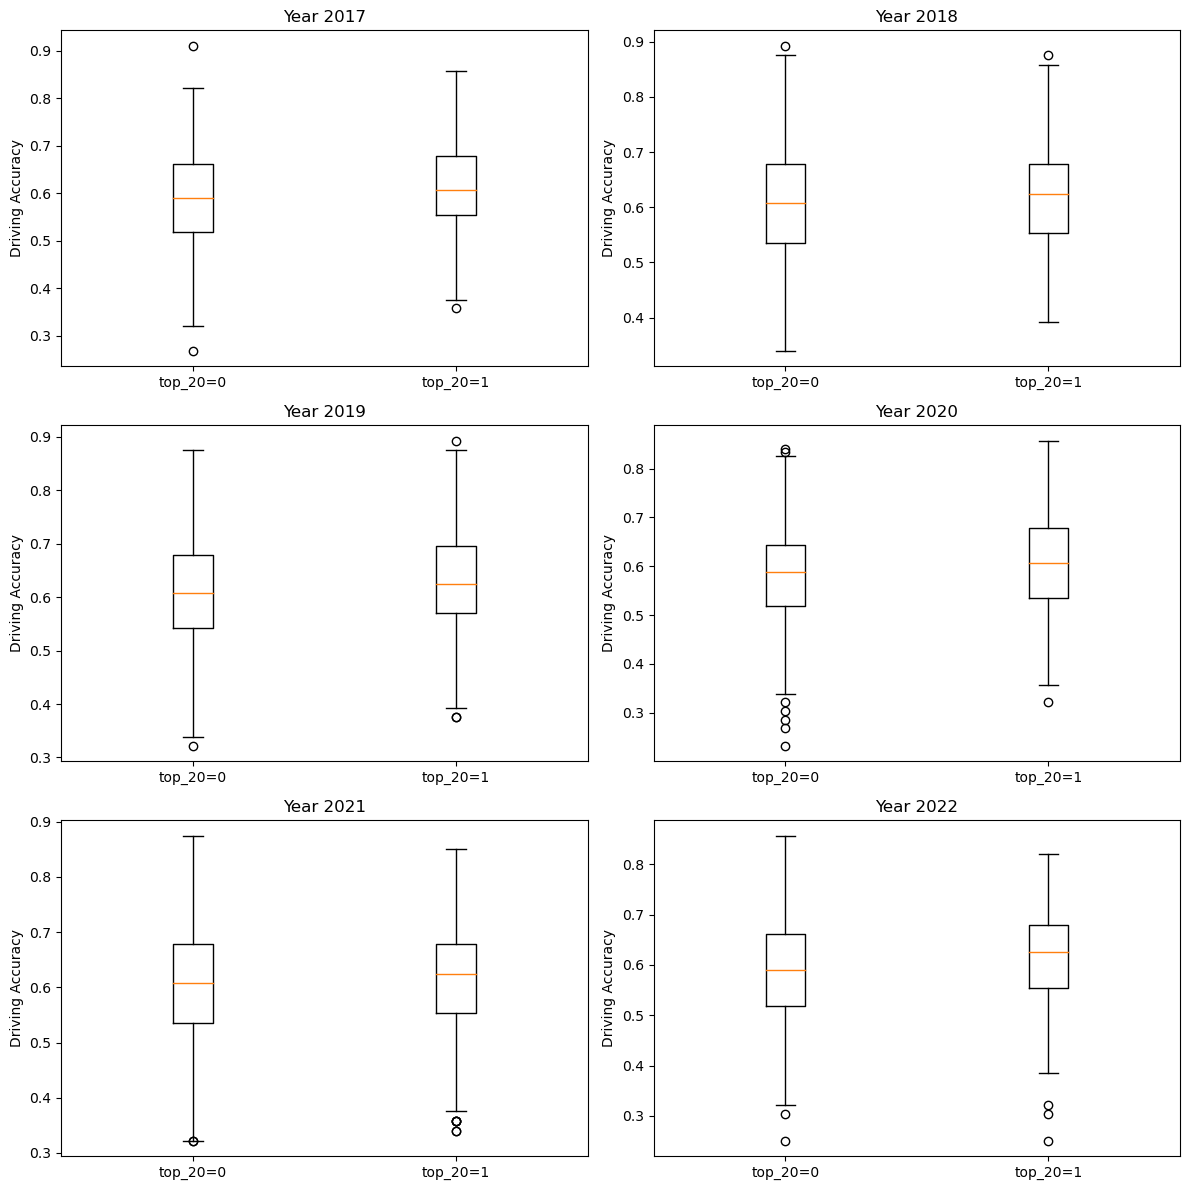

In [179]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

for year, axs in zip(np.unique(averaged_data['year'].values), axes.flatten()):
    # Get the driving distance data for top_20=0 and top_20=1 for the current year
    driving_acc_0 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 0)]['driving_acc']
    driving_acc_1 = averaged_data[(averaged_data['year'] == year) & (averaged_data['top_20'] == 1)]['driving_acc']
    
    # Create boxplots for the current year
    axs.boxplot([driving_acc_0, driving_acc_1], labels=['top_20=0', 'top_20=1'])
    axs.set_title(f'Year {year}')
    axs.set_ylabel('Driving Accuracy')

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()